In [344]:
from statsforecast import StatsForecast
import statsforecast.models as sf_model
from datasetsforecast.m4 import M4
import utilsforecast.losses as loss 
from utilsforecast.evaluation import evaluate

import pandas as pd

import math

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

### Data
---
Load in M4 hourly data. Just get the first 1 datasets.

In [47]:
df_all, *_ = M4.load('./data', 'Hourly')
df_all['ds'] = df_all['ds'].astype(int)

# Just pick out the first few datasets to work with.
n_series = 20
uids = df_all['unique_id'].unique()[:n_series]
df = df_all.query('unique_id in @uids').copy()

df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


In [46]:
ds = df.query("unique_id == 'H116'")
ds.head()

,unique_id,ds,y
14212,H116,1,4205.0
14213,H116,2,3939.0
14214,H116,3,3672.0
14215,H116,4,3384.0
14216,H116,5,3090.0


### 4 Basic Models
---
- Naive: The latest point is the best prediction.
- Mean: The average, literally.
- Seasonal naive: Add in the seasonal component if there is one.
- Drift

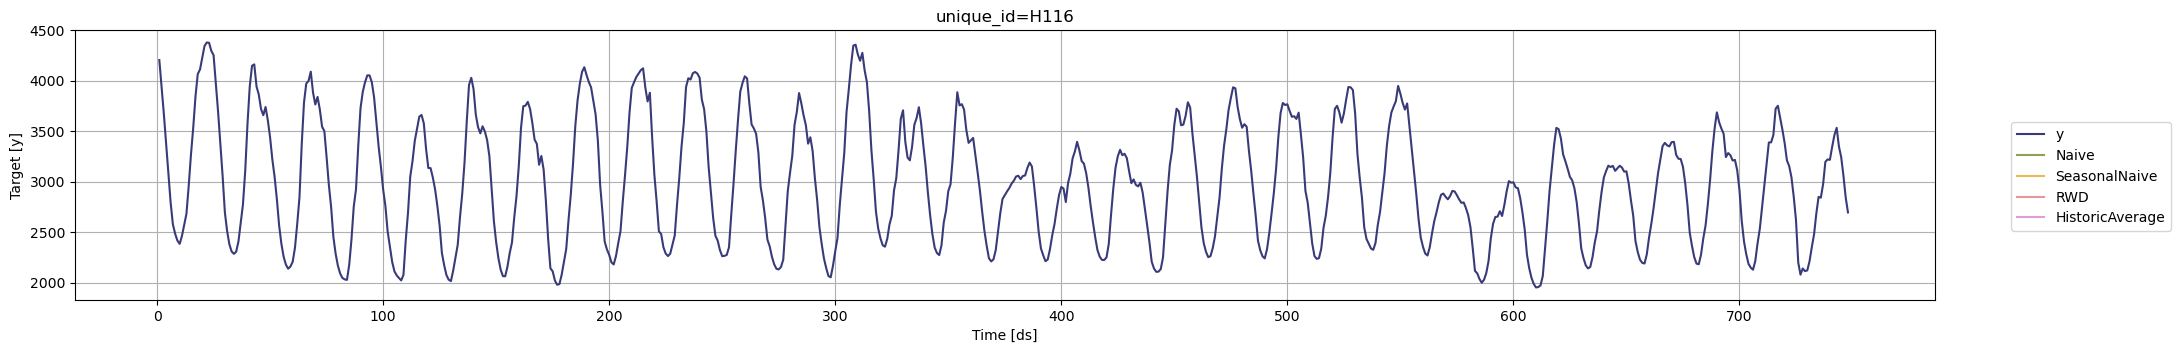

In [119]:
models = [sf_model.Naive(), sf_model.SeasonalNaive(24), sf_model.RandomWalkWithDrift(), sf_model.HistoricAverage()]

sf = StatsForecast(models=models, freq=1)
sf.fit(df=ds)

pred = sf.predict(h=1)

sf.plot(ds, pred)

In [319]:
df['unique_id'].unique()

array(['H1', 'H10', 'H100', 'H101', 'H102', 'H103', 'H104', 'H105',
       'H106', 'H107', 'H108', 'H109', 'H11', 'H110', 'H111', 'H112',
       'H113', 'H114', 'H115', 'H116'], dtype=object)

### Residuals
---
The difference between your prediction and ground truth.

In [160]:
rows = ds.shape[0]

preds = None

for row in range(24, rows):
    ds_temp = ds.head(row).copy()
    sf.fit(df=ds_temp)
    pred = sf.predict(h=1)
    
    preds = pd.concat([preds, pred])

In [186]:
preds = preds.set_index(ds.tail(rows-24).index)
preds['unique_id'] = 'H116'

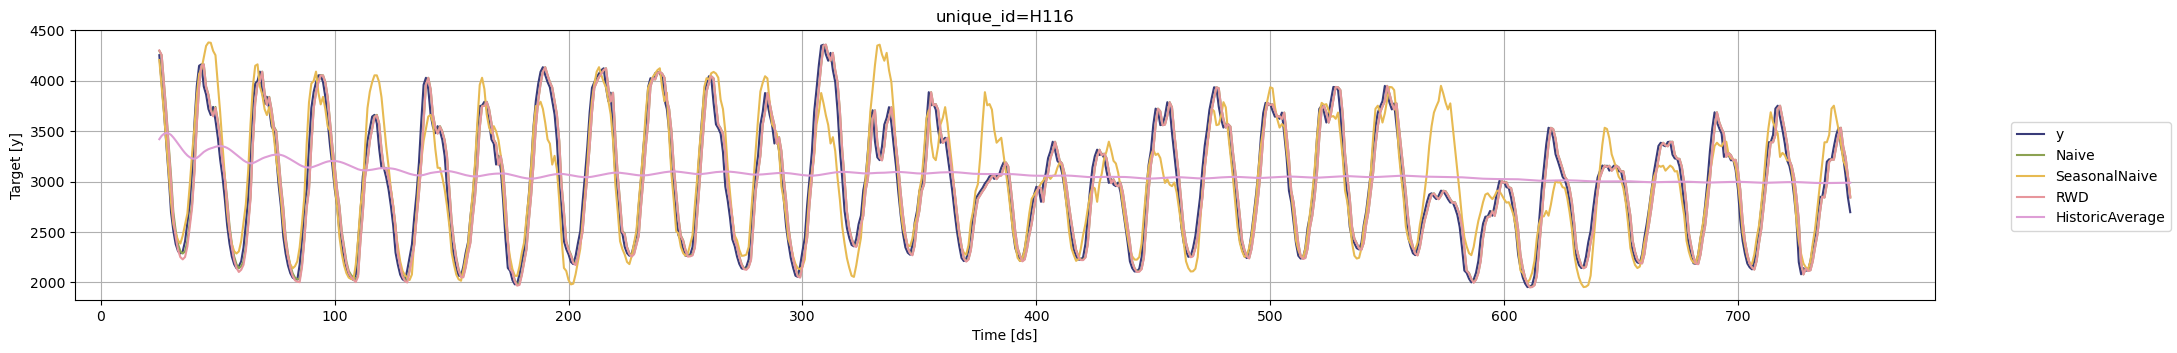

In [188]:
sf.plot(ds.tail(rows-24), preds)

In [199]:
models_str = list(map(lambda model: model.__str__(), models))

rmse = []
for model in models_str:
    rmse.append(math.sqrt(((ds['y'].tail(rows-24) - preds[model])**2).mean()))

print(f"RMSE: {list(zip(models_str, rmse))}")

RMSE: [('Naive', 171.38108968189135), ('SeasonalNaive', 266.5346266103533), ('RWD', 171.89798525224919), ('HistoricAverage', 604.9425204354649)]


### Cross-Validation
---

Like in the usual data science sense, hide a portion of your data and forecast the hidden information. This ends up being an $n$-way validation depending on the timestep and the horizon.

In [109]:
cv_ds = sf.cross_validation(df=ds, h=24, step_size=1, n_windows=1)
cv_ds['unique_id'] = cv_ds.index
cv_ds.head()

,ds,cutoff,y,Naive,SeasonalNaive,RWD,HistoricAverage,unique_id
unique_id,,,,,,,,
H116,725,724,2622.0,2853.0,2613.0,2851.130127,2994.421387,H116
H116,726,724,2200.0,2853.0,2410.0,2849.260010,2994.421387,H116
H116,727,724,2080.0,2853.0,2282.0,2847.390137,2994.421387,H116
H116,728,724,2141.0,2853.0,2187.0,2845.520020,2994.421387,H116
H116,729,724,2115.0,2853.0,2149.0,2843.650146,2994.421387,H116


In [111]:
evaluate(cv_ds, metrics=[loss.rmse, loss.mae], models=models_str)

,unique_id,metric,Naive,SeasonalNaive,RWD,HistoricAverage
0,H116,rmse,475.931183,204.567947,483.208496,515.457764
1,H116,mae,407.333344,148.208328,416.397430,432.438690


### Residual Randomness Testing
---
if your model of the time series data captures every pattern available in the data, then the leftover residuals should be white noise. We can test for this.

#### Ljung-Box Test
A modification of the Box-Pierce test.

$$Q = T\sum_{k=1}^l r_k^2$$

- $k$: $k$th lag
- $l$: the amount of lags to consider
- $T$: The total amount of data points
- $r_k$: The autocorrelation coefficient of lag $k$

A modification includes scaled by $T$ squared and scaling down the residuals. The intuition is that residuals are normally distributed, then a a chi-squared distribution can be used to test the statistic.

        lb_stat  lb_pvalue
10  1508.758493        0.0
        lb_stat  lb_pvalue
10  2111.873784        0.0
        lb_stat  lb_pvalue
10  1508.805926        0.0
        lb_stat  lb_pvalue
10  2408.949499        0.0


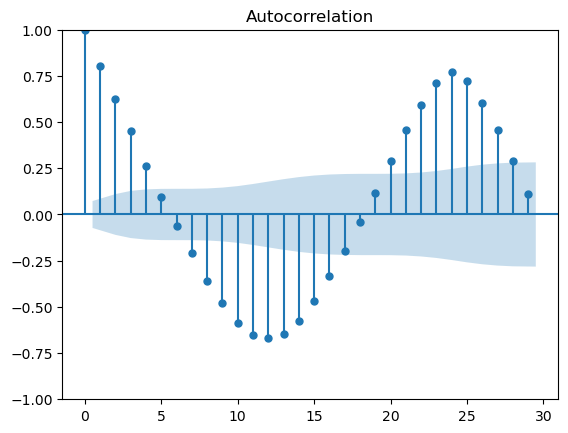

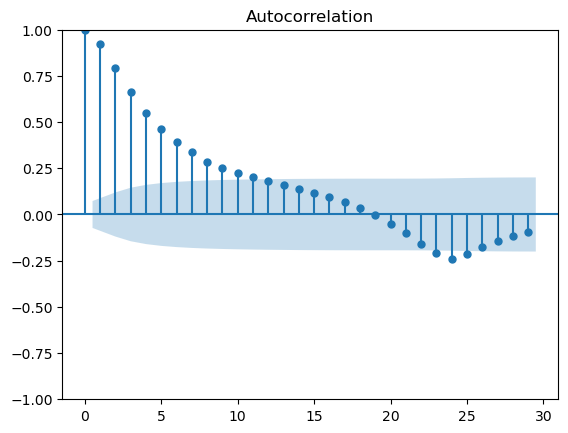

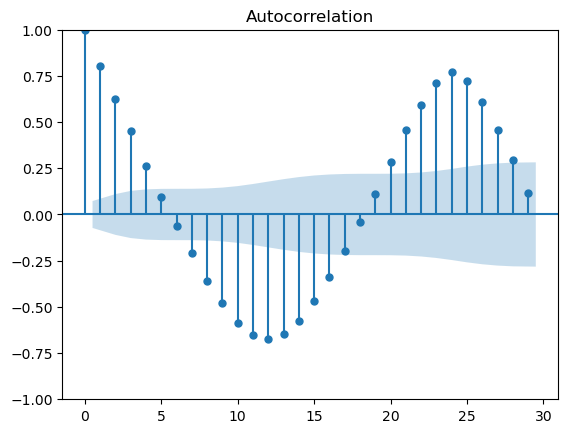

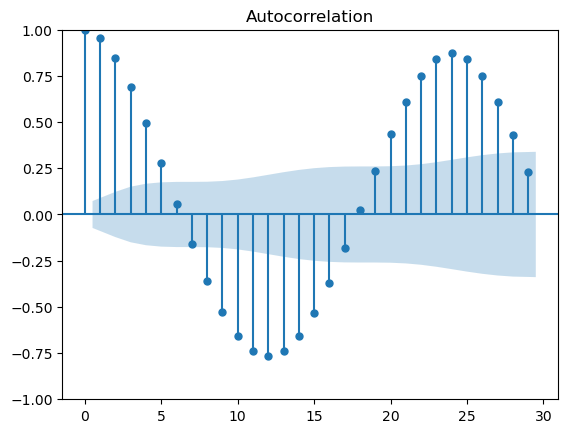

In [215]:
for model in models_str:
    res = (ds['y'].tail(rows-24) - preds[model])
    
    print(acorr_ljungbox(res, lags=[10]))
    plot_acf(res)

### Distributional Forecast
---
Instead of a point forecast, you can have a forecast with a range (assuming normality).

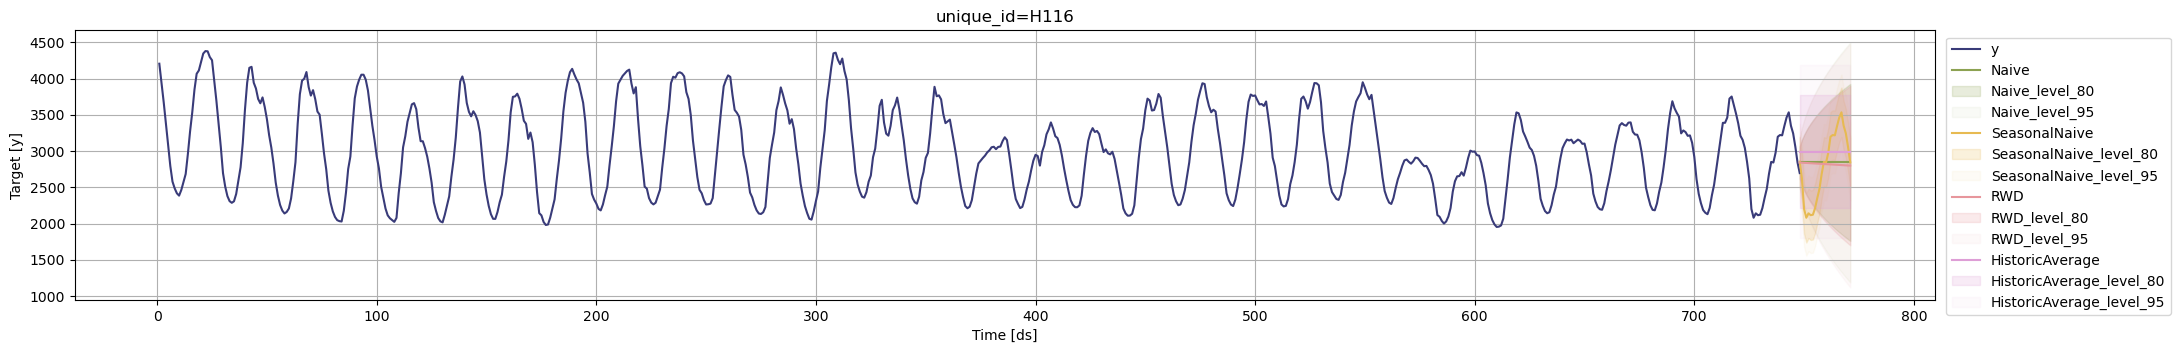

In [218]:
preds_dist = sf.predict(h=24, level=[80,95])
sf.plot(ds, preds_dist, level=[80, 95])

### Bootstrapping
---
If normality is too much of an assumption, you could just assume independent residuals and constant variance to generate prediction intervals. 

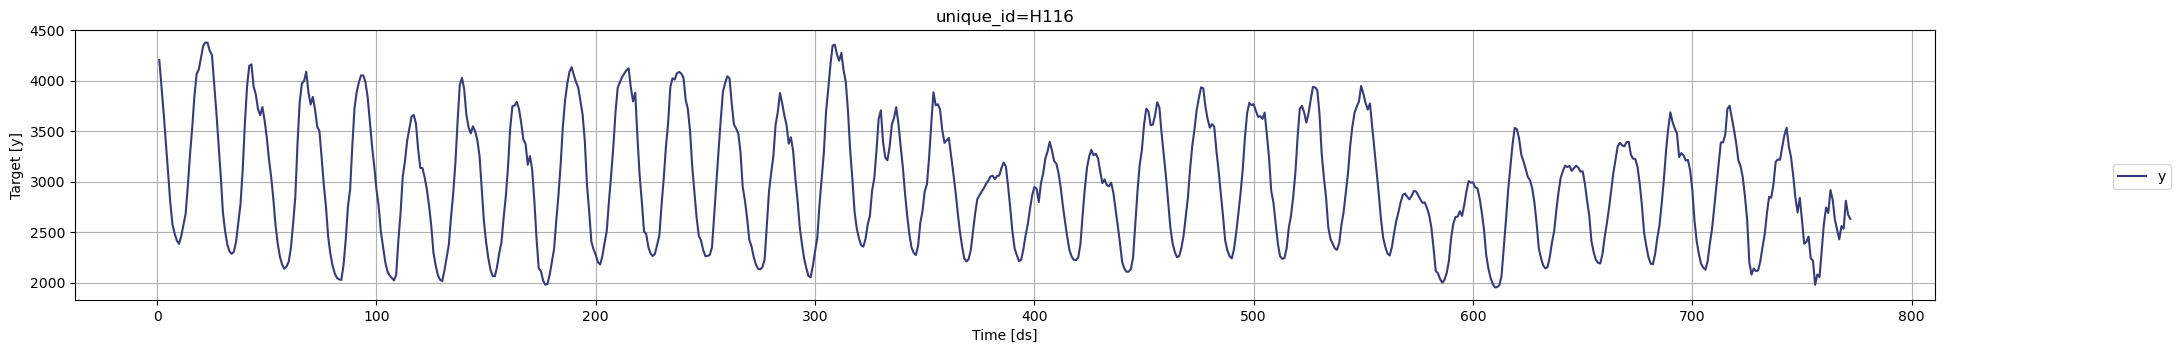

In [317]:
h = 24

res = (ds['y'].tail(rows-h) - preds['Naive'])

bs_size = 1

last_row = ds.tail(1)
forecast = res.sample(h).cumsum().add(last_row['y'].iloc[0])
forecast = pd.DataFrame(forecast, columns=['y'])
forecast['ds'] = list(range(last_row['ds'].iloc[0]+1, last_row['ds'].iloc[0]+h+1))
forecast['unique_id'] = 'H116'

sf.plot(ds, forecast)

### Back Transform Correction
---
When you make a prediction $\hat{w}_t$ where $g: y_t \mapsto w_t$ is a transformation, you have to correct for the back-transformation since it centers it on 0 when you made the prediction $\hat{w}_t$. I bias correction is needed to center on the the actual mean of the old distribution. Do a Taylor series expansion about the mean to correct for this.

$$Y= g(X) = g(\mu) + (X- \mu)g'(\mu) + (X-\mu)^2g''(\mu)$$

Take the expectation throughout.

$$\mathbb E[Y] = \mathbb E [g(X)] = g(\mu) + \frac{1}{2}\sigma^2 g''(\mu)$$

- $\mu$ is the mean of the distributional forecast you made in the transformed space
- $\sigma$ is pulled from the distributional forecast

### Forecasting with Decomposition
---
If we wish to be more sophisticated with our approach to forecasting, we can factor out the seasonal part and use two different forecasting algorithms to handle the seasonal and seasonally-adjusted part.

In [355]:
decomp = sm.tsa.seasonal_decompose(ds['y'], model='additive', period=24)

seasonal = decomp.seasonal
trend = decomp.trend
resid = decomp.resid

seasonally_adjusted = ds['y'] - seasonal

In [356]:
sf_naive = StatsForecast(models=[sf_model.Naive()], freq=1)
sf_snaive = StatsForecast(models=[sf_model.SeasonalNaive(24)], freq=1)

sf_naive.fit(ds.assign(y=seasonally_adjusted))
sf_snaive.fit(ds.assign(y=seasonal))

StatsForecast(models=[SeasonalNaive])

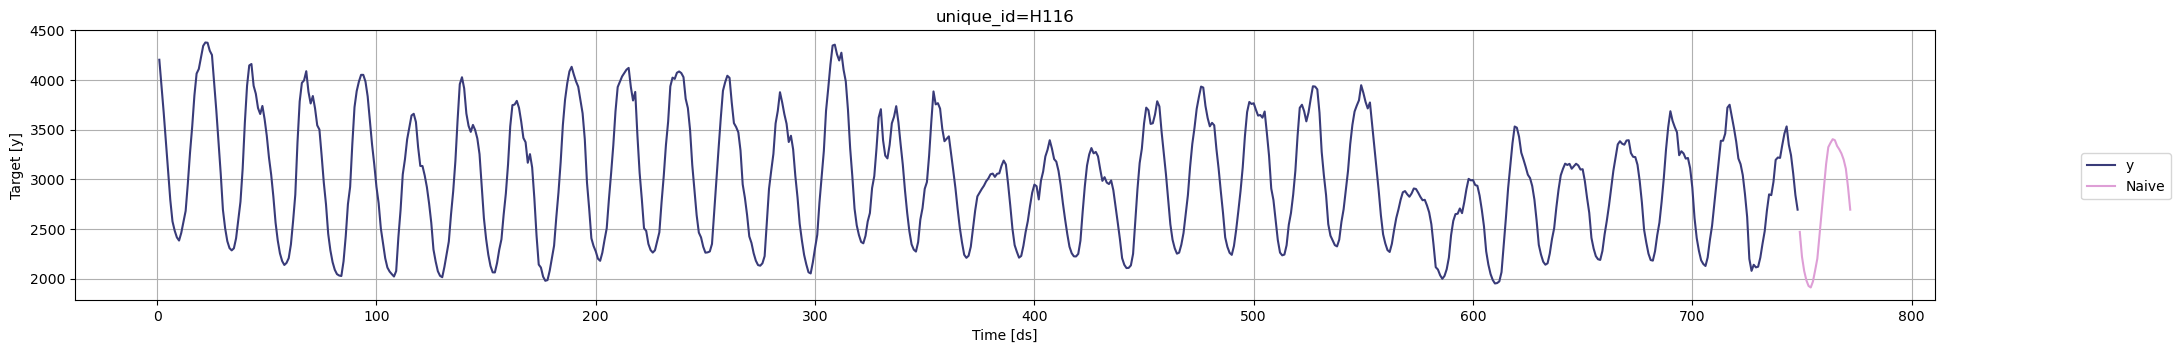

In [357]:
naive_pred = sf_naive.predict(24)
snaive_pred = sf_snaive.predict(24)

naive_pred['Naive'] = naive_pred['Naive'] + snaive_pred['SeasonalNaive']

sf.plot(ds, naive_pred)

In [376]:
rows = ds.shape[0]

preds = None

for row in range(48, rows):
    ds_cv = ds.head(row).copy()
    
    decomp = sm.tsa.seasonal_decompose(ds_cv['y'], model='additive', period=24)

    seasonal = decomp.seasonal
    trend = decomp.trend
    resid = decomp.resid

    seasonally_adjusted = ds_cv['y'] - seasonal
    sf_naive.fit(ds_cv.assign(y=seasonally_adjusted))
    sf_snaive.fit(ds_cv.assign(y=seasonal))
    
    naive_pred = sf_naive.predict(24).tail(1)
    snaive_pred = sf_snaive.predict(24).tail(1)
    
    naive_pred['Naive'] = naive_pred['Naive'] + snaive_pred['SeasonalNaive']

    preds = pd.concat([preds, naive_pred])

In [380]:
preds = preds.set_index(ds.tail(rows-48).index)
preds['unique_id'] = 'H116'

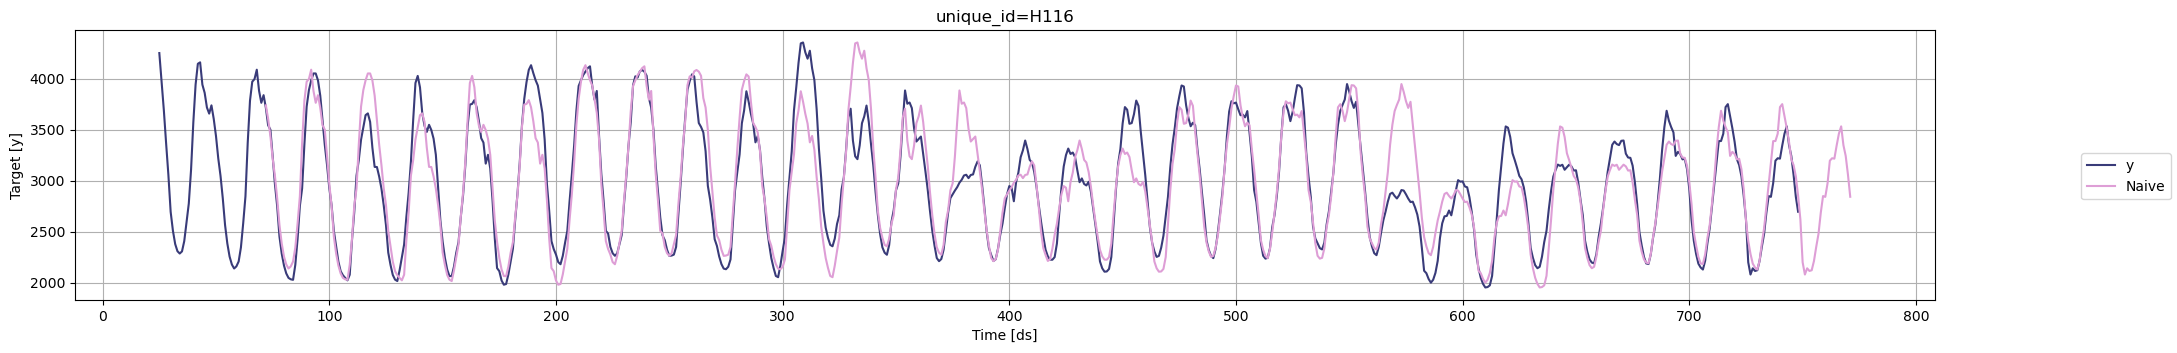

In [381]:
sf.plot(ds.tail(rows-24), preds)